# Full Intelligent Driver Model


##Parameters Setup


In [ ]:
Ncar = 20
def init_params():
  Nmax = 25             # maximum number of cars
  L = 1000              # length of ring road
  steps = 500           # total number of steps
  steps_measure = 15    # steps before we start to measure
  splim = 31.2928       # speed limit in m/s
  det_point = 200
       # location of a detection point - not needed initially

# In case of a detection loop add det_point to the end of params in params_setup

  return Nmax, L, steps, steps_measure, splim, det_point
init_params()

(25, 1000, 500, 15, 31.2928, 200)

In [ ]:
def params_setup(splim,L,current_weather):
  # key parameters - Fill in yourself
  des_speed=splim              # Desired speed
  des_speed_inv=1./splim       # Multiplication is faster than division
  del_t= 0.5                   # Time step in seconds
  acc_exp= 4                   # Acceleration exponent
  time_gap= 1                  # Time gap in seconds
  min_gap =  2                 # Spatial gap in meters
  comf_decel= 1.5              # Braking parameter in m/s2
  acc_max= 1                   # Maximum acceleration in m/s2
  length = 5                   # Car length in m

  #Params list set-up
  params=[]
  params.append(des_speed_inv)
  params.append(acc_exp)
  params.append(time_gap)
  params.append(comf_decel)
  params.append(min_gap)
  params.append(acc_max)
  params.append(del_t)
  params.append(length)
  params.append(L)

  if current_weather == "Clear":
      pass
  elif current_weather == "Rain":
      params[4] = 0.75
  elif current_weather == "Snow":
      params[4] = 0.75
      params[0] = 1 / 20.1168
  elif current_weather == "Wind":
      params[0] = 1 / 26.8224

  return params

In [ ]:
import numpy as np
import random as rd
Nmax, L, steps, steps_measure, splim, det_point = init_params()
params = params_setup(splim,L,'Clear')
length = params[7]
min_gap = params[4]
def init_simulation(Ncar,L,):
  fail_count = 0
  car1pos = L + 1
  vel_list= np.zeros(Ncar)       # initial velocity
  pos_list= np.zeros(Ncar)
  while car1pos> L - length and fail_count < 1000:
    for i in range(Ncar-1,-1,-1):
      ran_pos = rd.randint(0,5)
      if i == Ncar -1 :
        pos_list[i] = 0
      else:
        pos_list[i] = pos_list[i+1] + min_gap + length +ran_pos
    car1pos = pos_list[0]
    if car1pos > L:
      fail_count += 1
    if fail_count >= 1000:
      for i in range(Ncar-1,-1,-1):
        if i == Ncar -1 :
          pos_list[i] = 0
        else:
          pos_list[i] = pos_list[i+1] + min_gap + length

  dv_list=  np.zeros(Ncar)         # speed differential
  headway_list= np.zeros(Ncar)

  for i in range (Ncar):
    pos = pos_list[i]
    if i == 0:
      pos_Front = pos_list[Ncar-1]
    else:
      pos_Front = pos_list[i-1]
    headway = (pos_Front - pos) - length
    if pos_Front < pos:
     headway = (pos_Front + L - pos) - length
    headway_list[i] = headway

  return vel_list, pos_list, dv_list, headway_list

init_simulation(Ncar,L)



(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([194., 186., 175., 165., 153., 142., 132., 122., 114., 102.,  90.,
         79.,  68.,  61.,  51.,  39.,  29.,  21.,  11.,   0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([801.,   3.,   6.,   5.,   7.,   6.,   5.,   5.,   3.,   7.,   7.,
          6.,   6.,   2.,   5.,   7.,   5.,   3.,   5.,   6.]))

# **Main Functions of the model**


1.   Updating Car Postion and Velocity
2.   Determine whether a Car has passed a Detection Point
3.   Single-step propagation of the IDM model
4.   Update car data needed for next simulation step
5.   Single-step propagation of the IDM model
6.   Analysis of Flow and Density
7.   Full simulation of the IDM model
8.   Sweeping oveer Different Parameters

In [ ]:
#########################################################################
#      1. UPD_POS_VEL, with headway and dv calculated inside the function
#########################################################################
import numpy as np
def upd_pos_vel(Ncar, pos_list, vel_list, acc_list, headway_list, dv_list,posnew_list,velnew_list, params):

  """For each car, calculates the acceleration and the resulting position and velocity at the end of the step.

  I/O arguments:
    Ncar = number of cars
    pos = car's position
    vel = car's velocity
    acc = car's acceleration
    headway = headway (see exact definition in book/Canvas)
    dv = velocity difference wrt preceeding car (see exact definition in book/Canvas)

    velnew = car's new velocity
    params = list including key parameters
  """
  accnew_list = np.zeros(Ncar)
  des_speed_inv = params[0]
  acc_exp       = params[1]
  time_gap      = params[2]
  comf_decel    = params[3]
  min_gap       = params[4]
  acc_max       = params[5]
  del_t         = params[6]

  # Define speed limit zone
  speed_limit_start_pos = 500.0
  speed_limit_end_pos   = 700.0
  speed_limit_value     = 13.41  # ~48.18 km/h, example
  speed_limit_inv       = 1 / speed_limit_value


  # For all cars
  for i in range(Ncar):
      vel = vel_list[i]
      dv = dv_list[i]
      headway = headway_list[i]

    # Check if the car is within the speed limit zone
      if speed_limit_start_pos <= pos_list[i] <= speed_limit_end_pos:
          # Override the normal desired speed
          local_des_speed_inv = speed_limit_inv
      else:
          local_des_speed_inv = des_speed_inv

      # Compute s_star
      s_star = min_gap + max(0.0,vel * time_gap + (vel * dv) / (2.0 * np.sqrt(acc_max * comf_decel)))

      if headway > 0:
          acc = acc_max * (1.0 - (vel * local_des_speed_inv) ** acc_exp - (s_star / headway) ** 2)
      else:
          acc = -comf_decel  # or some fallback
      acc_list[i] = acc
      accnew_list[i] = acc

  # For all cars,
  for i in range(Ncar):
    vel = vel_list[i]
    acc = acc_list[i]
    pos = pos_list[i]
    if acc != 0:
      del_t_star = -vel/acc
    else:
      del_t_star = 0
    posnew = pos + vel * del_t + 0.5 * acc * del_t**2
    velnew = vel + acc*del_t
    if velnew < 0:
      posnew = pos + vel * del_t_star + (0.5 * acc * (del_t_star**2))
      velnew = vel + acc*del_t_star

    if posnew > L:
      posnew = posnew - L
    posnew_list[i] = posnew
    velnew_list[i] = velnew

  return posnew_list, velnew_list, accnew_list


## Detection Loop


In [ ]:
def detect_loop(Ncar,pos,vel,acc,posnew,velnew, detect_time, detect_vel, det_point, time_pass):

# For all cars
  for i in range(Ncar):

# Check whether a car has just passed the detection point
# If so, determine the moment and speed when crossing this point
# INSERT CODE here

    if (posnew[i] > det_point) and (pos[i] < det_point):
      detect_time = np.append(detect_time,time_pass)
      detect_vel = np.append(detect_vel,velnew[i])

  return detect_time, detect_vel
# NB To set up this function you may require some start-up time for proper determination


## Update car data needed for next simulation step.

Update the postion and velocity for each car

In [ ]:
def update_cars(Ncar, pos_list, vel_list, posnew_list, velnew_list, headway_list, dv_list, params):
   """   For each car, update the position and velocity

    I/O arguments:
      Ncar = number of cars
      pos = car's position
      vel = car's velocity
      acc = car's acceleration
      headway = headway
      dv = velocity differential wrt preceeding car
      posnew = car's new position
      velnew = car's new velocity
      params = list including key parameters
   """

# Extract the key parameters from params
   length  = params[7]
   L       = params[8]
   min_gap = params[4]

# For all cars
   for i in range (Ncar):
    pos_list[i] = posnew_list[i]
    vel_list[i] = velnew_list[i]
# Update position and velocity
# Take note that the road forms a ring!

   headwaynew_list = np.zeros(Ncar)
   dvnew_list = np.zeros(Ncar)

# INSERT CODE here

   for i in range(Ncar):
    vel = vel_list[i]
    if i == 0:
      vel_Front = vel_list[Ncar - 1]
    else:
      vel_Front = vel_list[i-1]
    dv = vel - vel_Front

    dvnew_list[i] = dv

    pos = pos_list[i]

    if pos >= L:
      pos_list[i] = pos - L
    else:
      pos_list[i] = pos

    if i == 0:
      pos_Front = pos_list[Ncar-1]
    else:
      pos_Front = pos_list[i-1]
    headway = (pos_Front - pos) - length
    if pos_Front < pos:
     headway = (pos_Front + L) - pos - length
    headwaynew_list[i] = headway

# For all cars
   for i in range(Ncar):
    dv_list[i] = dvnew_list[i]
    headway_list[i] = headwaynew_list[i]



# update the headway and the speed differential between cars
#   Note that the car in front may be at the start of the ring!
#   You can also put in a check that safety margins are maintained

# INSERT CODE here

# We have updated all information needed for the time step.
   return pos_list, vel_list, headway_list, dv_list

## Single-step propagation of the IDM model

This routine calls all the functions required to propagate the model for a single time step and calls the function to determine the global flow.

It will need to be modified only when a local detection loop is being implemented.

In [ ]:
Nmax, L, steps, steps_measure, splim, det_point = init_params()
params = params_setup(splim,L,'clear')
vel_list, pos_list, dv_list, headway_list = init_simulation(Ncar,L)


def Step(N,pos_list,vel_list,headway_list,dv_list,params,time_pass,time_measure, detect_time, detect_vel):
#
# initialise several arrays to 0
#
    posnew_list=np.zeros(N)
    velnew_list=np.zeros(N)
    acc_list= np.zeros(N)
    den = "undefined"
    flo = "undefined"

# Determine the position, velocity at end of interval and acceleration at start
# Do not update the positions just yet, as they may be needed within the detection loop

    posnew_list, velnew_list, acc_list = upd_pos_vel(N, pos_list, vel_list, acc_list, headway_list, dv_list, posnew_list, velnew_list, params)

# Second phase: After a certain number of steps, activate the detection loop
#               for determining local flow/density at the detection point
    time_measure = 5
    if (time_pass > time_measure):

#  MODIFY CODE HERE FOR DETECTION LOOP
        detect_time, detect_vel = detect_loop(N, pos_list, vel_list, acc_list, posnew_list, velnew_list, detect_time, detect_vel, det_point, time_pass)
        den,flo = flow_global(N,velnew_list,L)


    else:
        detect_time = np.array([])
        detect_vel = np.array([])
# Now we can update the key parameters needed for the next iteration
    pos_list, vel_list, headway_list, dv_list = update_cars(N, pos_list, vel_list, posnew_list, velnew_list, headway_list, dv_list, params)

# MODIFY OUTPUT FOR DETECTION LOOP
    return pos_list, vel_list, headway_list, dv_list, den, flo , detect_time, detect_vel

# NOTE: the output data for analysis should be stored in a list / array.
#       you do not know the number of data points in detect_time
#       and detect_vel in advance.
#       Storing the data occurs in run_simulation
del_t = 0.5
for i in range(300):
  time_pass = i * del_t
  time_measure = 5

## Analsying Flow and Density

Used to calculate the main data of the simulation

In [ ]:
import math as mt
Nmax, L, steps, steps_measure, splim, det_point = init_params()
def flow_global(Ncar,vel_list,road_l):
  vel_sum = 0
  vel_list_hr=vel_list*3.6
  road_l_km=road_l/1000
  for i in range(Ncar):
    vel_sum = vel_sum + (vel_list_hr[i])
  vel_avg = vel_sum/Ncar
  dens = (Ncar/(road_l_km))
  flow = vel_avg * dens      # m/s * cars/m, cars/hour
  return dens, flow


def analyse_global(track_flow, track_dens):

    time_pass = steps * del_t
    glob_flow = np.mean(track_flow)


    # Calculate overall global density (average of all densities)
    glob_dens = sum(track_dens) / len(track_dens) if len(track_dens) > 0 else 0
    return glob_flow, glob_dens

def analyse_local(detect_time, detect_vel, local_flow, local_dens):


    if detect_time.size == 0:
        local_flow.append(0)
        local_dens.append(0)
        return local_flow, local_dens
    timeCar1 = detect_time[0]
    timeCar2 = detect_time[len(detect_time)-1]
    time_pass_local =  detect_time[len(detect_time)-1] - detect_time[0]


    flow = len(detect_time)*3600 / time_pass_local
    avg_vel = np.mean(detect_vel)
    avg_vel_km_per_hour = avg_vel * 3.6
    dens = (flow / avg_vel_km_per_hour) * 1000

    local_flow.append(flow)
    local_dens.append(dens)



    return local_flow, local_dens

## Full simulation of the IDM model

This routine reads is provided with the calculation parameters and the number of cars. It then runs the simulation, and receives the global flow data for each time step.

At the end of the run, this overall data set needs to be analysed to return a specific value for the global flow and global density for this particular simulation.


Once a detection loop is set up, some modifications are needed to enable the determination of the local flow and local density. Initially, no changes should be necessary.

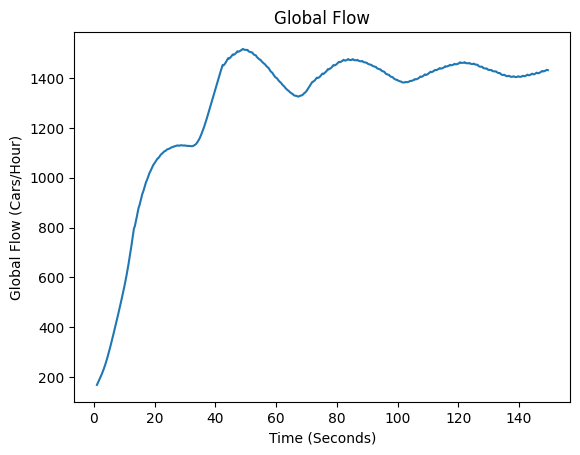

In [ ]:
import matplotlib.pyplot as plt

def Simulate_IDM(Ncar,params,steps,steps_measure):

  Nmax, L, steps, steps_measure, splim, det_point = init_params()
  global global_flow_list
  L = params[8]
  del_t = params[6]
  track_det_time=[]
  track_det_vel=[]
  detect_vel = np.array([])
  detect_time = np.array([])


  track_flow=[]
  track_dens=[]
  local_dens = []
  local_flow = []
  vel_list, pos_list, dv_list, headway_list = init_simulation(Ncar,L)
  global Take_flow
  Take_flow = True   # set to false
  reset = True       # set to false



  for i in range(steps):

    time_pass = i * del_t
    time_measure = 5
    dens, flow = flow_global(Ncar,vel_list,L)
    track_dens.append(dens)
    track_flow.append(flow)
    if (time_pass > time_measure):

        pos_list, vel_list, headway_list, dv_list, den, flo, detect_time, detect_vel = Step(Ncar,pos_list,vel_list,headway_list,dv_list,params,time_pass,time_measure,detect_time,detect_vel)

        glob_flow_list.append(flo)
# Add lines to store the generated data in the track lists
    else:

        pos_list, vel_list, headway_list, dv_list, den, flo , detect_time, detect_vel = Step(Ncar,pos_list,vel_list,headway_list,dv_list,params,time_pass,time_measure,detect_time,detect_vel)

    glob_flow, glob_dens = analyse_global(track_flow, track_dens)

  local_flow, local_dens = analyse_local(detect_time, detect_vel, local_flow, local_dens)
  local_flow = np.mean(local_flow)
  local_dens = np.mean(local_dens)

  avg_vel_local = np.mean(detect_vel)
  avg_vel_global = np.mean(vel_list)

  return glob_flow, glob_dens , local_flow, local_dens, avg_vel_local, avg_vel_global

glob_flow_list = []

glob_flow, glob_dens , local_flow, local_dens, avg_vel_local, avg_vel_global = Simulate_IDM(Ncar,params,steps,steps_measure)



time = np.linspace(1,time_pass,len(glob_flow_list))
plt.plot(time, glob_flow_list)
plt.xlabel("Time (Seconds)")
plt.ylabel("Global Flow (Cars/Hour)")
plt.title("Global Flow")
plt.show()


### Main code: Carry out a set of IDM simulations incorporating a sweep over car numbers

This code will run the main simulation. It will carry out a sweep over car numbers and carry out a plot for the main data such as global flow, global density and their local counterparts.

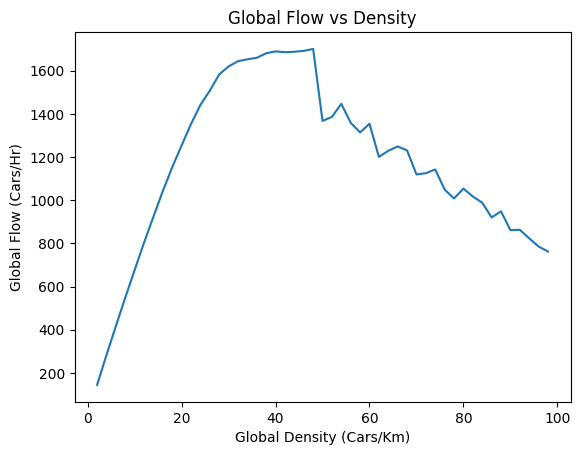

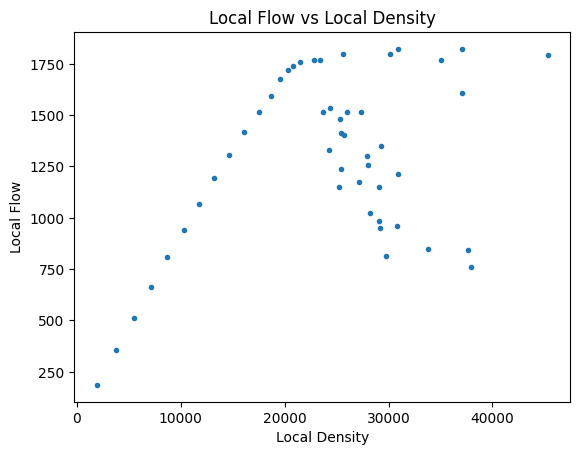

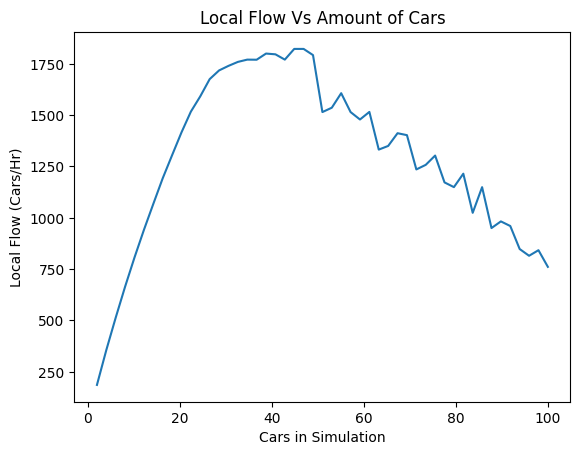

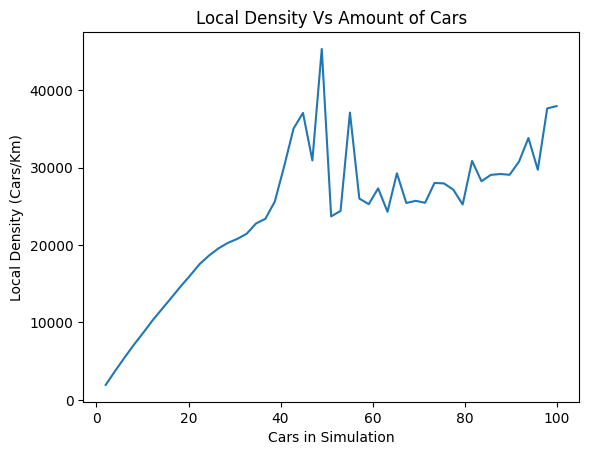

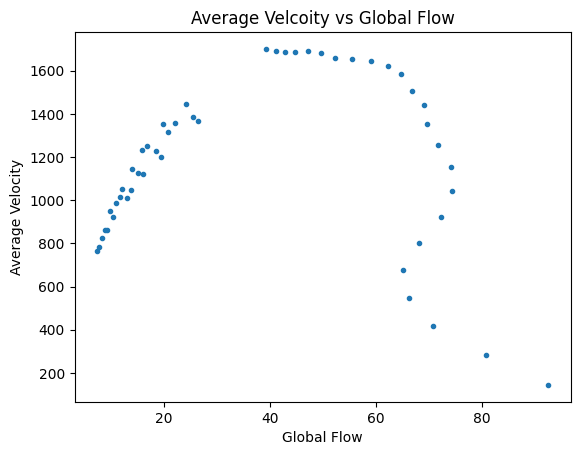

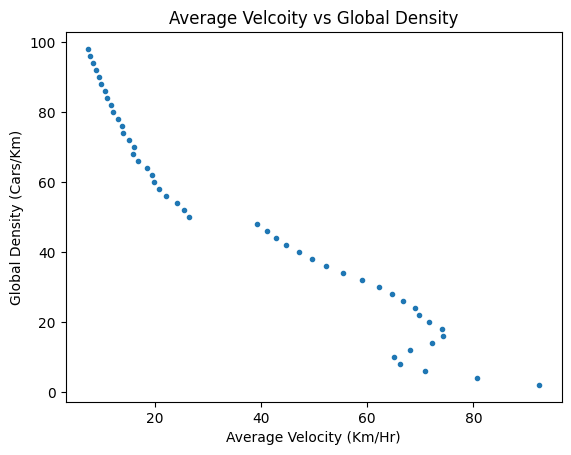

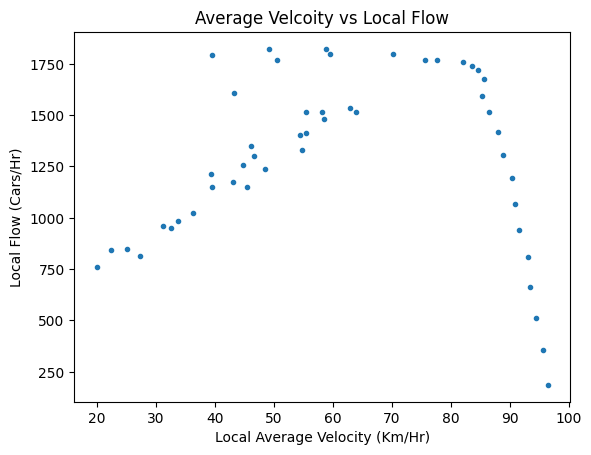

Average Velcoity vs Local Density


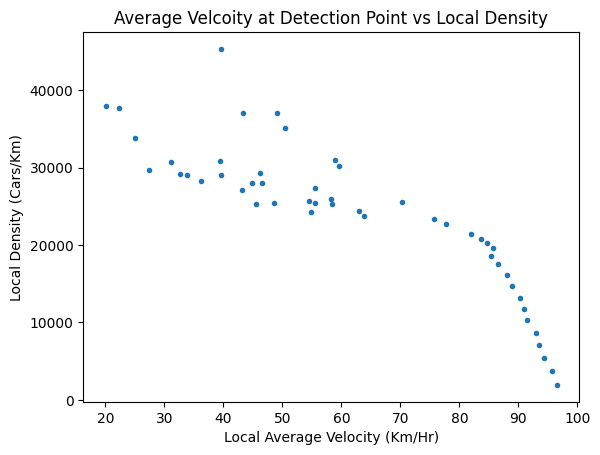

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#
# set up model parameters and road parameters
#
Nmax, L, steps, steps_measure, splim, det_point = init_params()
#
# parameters for the sweep
#
start_cars = 2
end_cars   = 100
step_cars  = 2
#
# initialise empty lists for the essential data
# data needs retaining for each number of cars in the sweep
#
global_flow   = []
local_flow    = []
global_dens   = []
local_dens    = []
global_av_vel = []
local_av_vel  = []


for N in range(start_cars,end_cars, step_cars):


  glob_flow, glob_dens , loc_flow, loc_dens, avg_vel_local, avg_vel_global = Simulate_IDM(N,params,steps,steps_measure)
  global_flow.append(glob_flow)
  local_flow.append(loc_flow)

  avg_vel_km_per_hour = avg_vel_global * 3.6
  avg_vel_km_per_hour_local = avg_vel_local * 3.6

  global_av_vel.append(avg_vel_km_per_hour)
  local_av_vel.append(avg_vel_km_per_hour_local)

  global_dens.append(glob_dens)
  local_dens.append(loc_dens)

car = np.linspace(start_cars,end_cars,len(global_flow))
Cars = np.array(car)
plt.plot(global_dens,global_flow)
plt.title("Global Flow vs Density")
plt.xlabel("Global Density (Cars/Km)")
plt.ylabel("Global Flow (Cars/Hr)")
plt.show()


#Loc Flow v Density Scatter
plt.scatter(local_dens,local_flow,marker=".")
plt.title("Local Flow vs Local Density")
plt.xlabel("Local Density")
plt.ylabel("Local Flow")
plt.show()

plt.plot(Cars,local_flow)
plt.title("Local Flow Vs Amount of Cars")
plt.xlabel("Cars in Simulation")
plt.ylabel("Local Flow (Cars/Hr)")
plt.show()

plt.plot(Cars,local_dens)
plt.title("Local Density Vs Amount of Cars")
plt.xlabel("Cars in Simulation")
plt.ylabel("Local Density (Cars/Km)")
plt.show()

#print("average velcoity vs global flow")
plt.scatter(global_av_vel, global_flow,marker='.')
plt.title("Average Velcoity vs Global Flow")
plt.xlabel("Global Flow")
plt.ylabel("Average Velocity")
plt.show()
#print("average velcoity vs global density")
plt.scatter( global_av_vel, global_dens, marker='.' )
plt.title("Average Velcoity vs Global Density")
plt.xlabel("Average Velocity (Km/Hr)")
plt.ylabel("Global Density (Cars/Km)")
plt.show()
#print("average velcoity vs local flow")
plt.scatter(local_av_vel, local_flow,marker='.')
plt.title("Average Velcoity vs Local Flow")
plt.xlabel("Local Average Velocity (Km/Hr)")
plt.ylabel("Local Flow (Cars/Hr)")
plt.show()
print("Average Velcoity vs Local Density")
plt.scatter(local_av_vel,local_dens, marker='.')
plt.title("Average Velcoity at Detection Point vs Local Density")
plt.xlabel("Local Average Velocity (Km/Hr)")
plt.ylabel("Local Density (Cars/Km)")
plt.show()

## Simulating for Different Weather Conditions

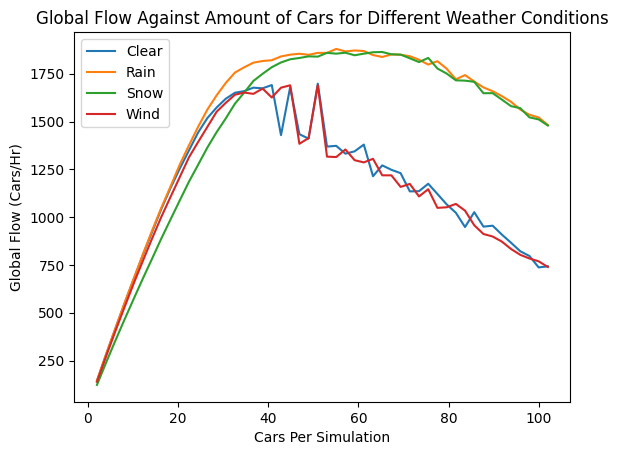

Peak Global Flow 1690.492619629443


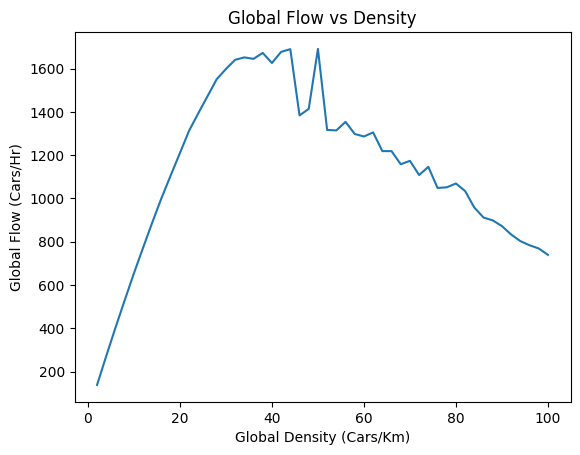

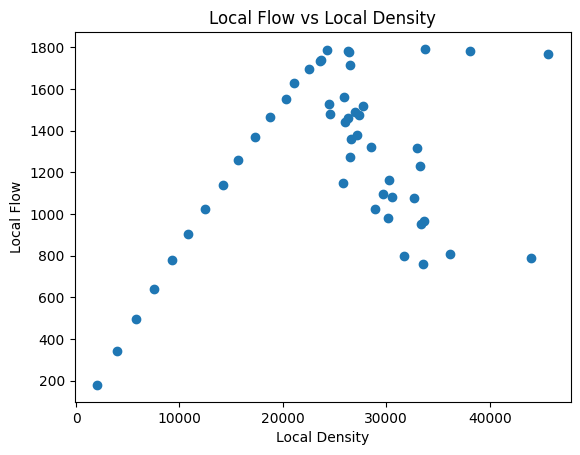

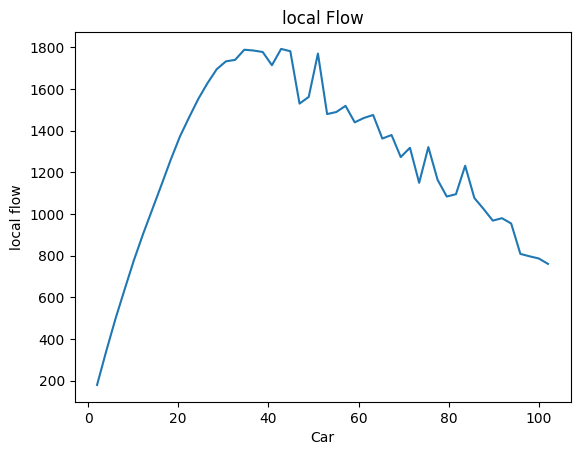

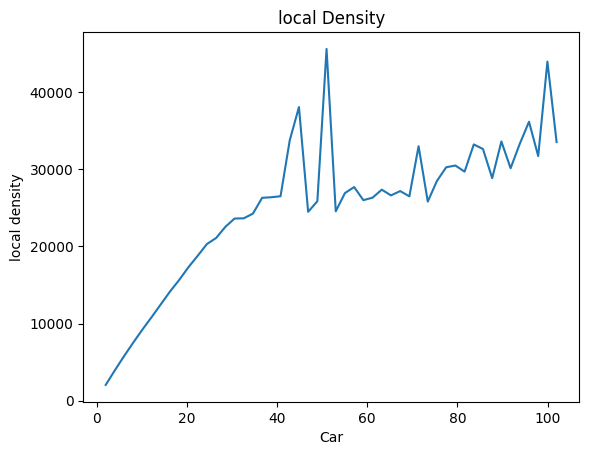

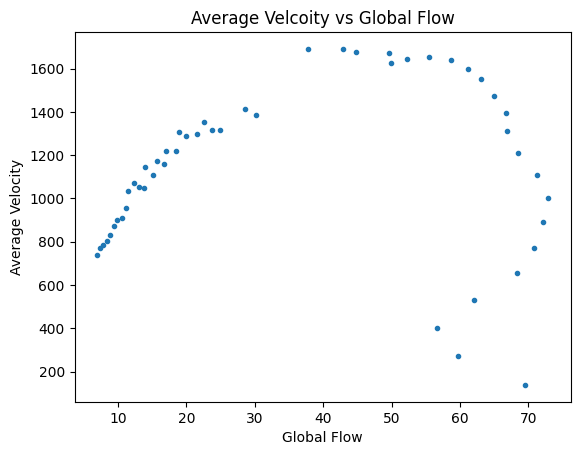

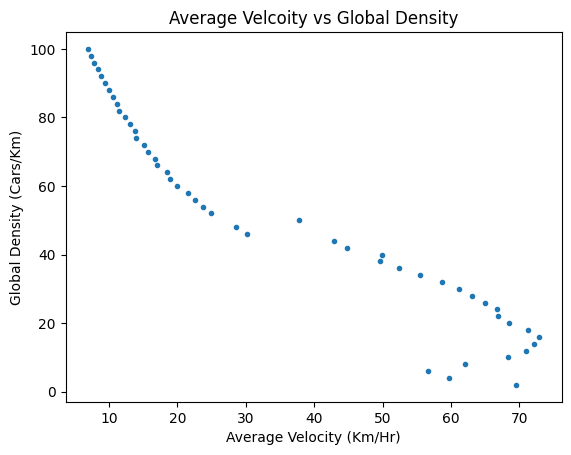

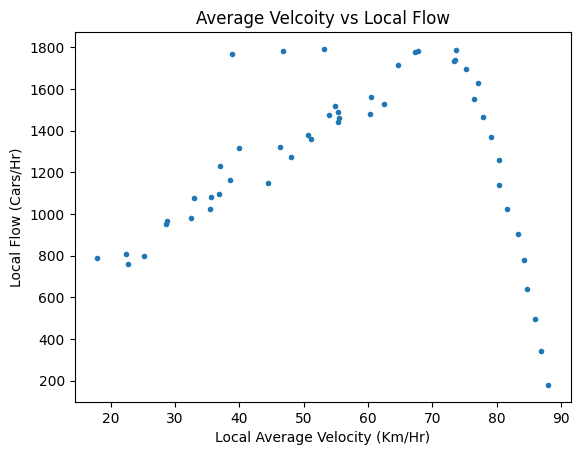

Average Velcoity vs Local Density


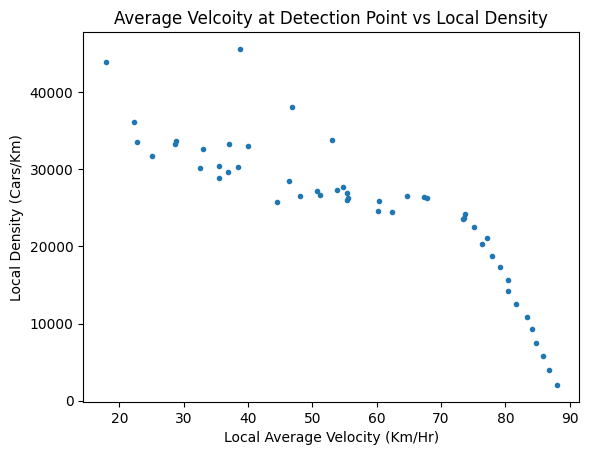

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#
# set up model parameters and road parameters
#
Nmax, L, steps, steps_measure, splim, det_point = init_params()
#
# parameters for the sweep
#
start_cars = 2
end_cars   = 102
step_cars  = 2
steps = int((end_cars - start_cars)/step_cars)
#
# initialise empty lists for the essential data
# data needs retaining for each number of cars in the sweep
#

globDensWeather = []
globflowweather = []

weather_conditions = ["Clear", "Rain", "Snow", "Wind"]
for j in range (len(weather_conditions)):
  global_flow   = []
  local_flow    = []
  global_dens   = []
  local_dens    = []
  global_av_vel = []
  local_av_vel  = []

  weather_conditions = ["Clear", "Rain", "Snow", "Wind"]
  car = np.linspace(start_cars,end_cars, steps)
  Cars = np.array(car)


  current_weather = weather_conditions[j]
  params = params_setup(splim,L,current_weather)
  for N in range(start_cars,end_cars, step_cars):

    glob_flow, glob_dens , loc_flow, loc_dens, avg_vel_local, avg_vel_global = Simulate_IDM(N,params,steps,steps_measure)

    global_flow.append(glob_flow)
    local_flow.append(loc_flow)

    avg_vel_km_per_hour = avg_vel_global * 3.6
    avg_vel_km_per_hour_local = avg_vel_local * 3.6

    global_av_vel.append(avg_vel_km_per_hour)
    local_av_vel.append(avg_vel_km_per_hour_local)


    global_dens.append(glob_dens)
    local_dens.append(loc_dens)


  globDensWeather.append(global_dens)
  globflowweather.append(global_flow)

  plt.plot(Cars,globflowweather[j])
  plt.legend(weather_conditions)
  plt.title("Global Flow Against Amount of Cars for Different Weather Conditions")
  plt.xlabel("Cars Per Simulation")
  plt.ylabel("Global Flow (Cars/Hr)")

plt.show()


car = np.linspace(start_cars,end_cars,len(global_flow))
Cars = np.array(car)
print('Peak Global Flow', max(global_flow))

plt.plot(global_dens,global_flow)
plt.title("Global Flow vs Density")
plt.xlabel("Global Density (Cars/Km)")
plt.ylabel("Global Flow (Cars/Hr)")
plt.show()


plt.scatter(local_dens,local_flow)
plt.title("Local Flow vs Local Density")
plt.xlabel("Local Density")
plt.ylabel("Local Flow")
plt.show()

plt.plot(Cars,local_flow)
plt.title("local Flow")
plt.xlabel("Car")
plt.ylabel("local flow")
plt.show()

plt.plot(Cars,local_dens)
plt.title("local Density")
plt.xlabel("Car")
plt.ylabel("local density")
plt.show()

#print("average velcoity vs global flow")
plt.scatter(global_av_vel, global_flow,marker='.')
plt.title("Average Velcoity vs Global Flow")
plt.xlabel("Global Flow")
plt.ylabel("Average Velocity")
plt.show()
#print("average velcoity vs global density")
plt.scatter( global_av_vel, global_dens, marker='.' )
plt.title("Average Velcoity vs Global Density")
plt.xlabel("Average Velocity (Km/Hr)")
plt.ylabel("Global Density (Cars/Km)")
plt.show()
#print("average velcoity vs local flow")
plt.scatter(local_av_vel, local_flow,marker='.')
plt.title("Average Velcoity vs Local Flow")
plt.xlabel("Local Average Velocity (Km/Hr)")
plt.ylabel("Local Flow (Cars/Hr)")
plt.show()
print("Average Velcoity vs Local Density")
plt.scatter(local_av_vel,local_dens, marker='.')
plt.title("Average Velcoity at Detection Point vs Local Density")
plt.xlabel("Local Average Velocity (Km/Hr)")
plt.ylabel("Local Density (Cars/Km)")
plt.show()

## Sweeping over the Length of the Road

2015.6586554515554 global flow
30.0 global density
2178.1512605042017 local flow
30700.668726943495 local density
1749.801675377262 global flow
28.571428571428857 global density
1894.7368421052631 local flow
26492.97918863567 local density
1652.339918584662 global flow
27.27272727272749 global density
1788.6315789473683 local flow
24872.0011665996 local density
1548.2059117818735 global flow
26.086956521739374 global density
1689.6405919661734 local flow
23186.759632818397 local density
1483.2554083357957 global flow
25.0 global density
1615.0943396226414 local flow
22408.536768215476 local density
1409.3773762807941 global flow
24.0 global density
1549.367088607595 local flow
21171.748608745504 local density
1346.6318747401433 global flow
23.076923076923173 global density
1479.245283018868 local flow
20317.72321694556 local density
1283.662688607864 global flow
22.22222222222246 global density
1415.644820295983 local flow
19344.922699279905 local density
1227.9811119070657 global flow

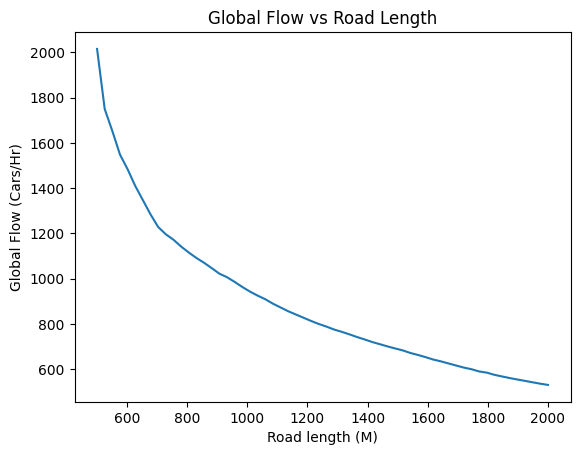

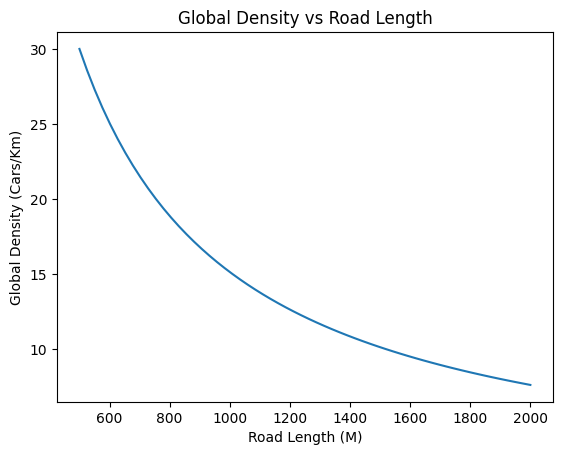

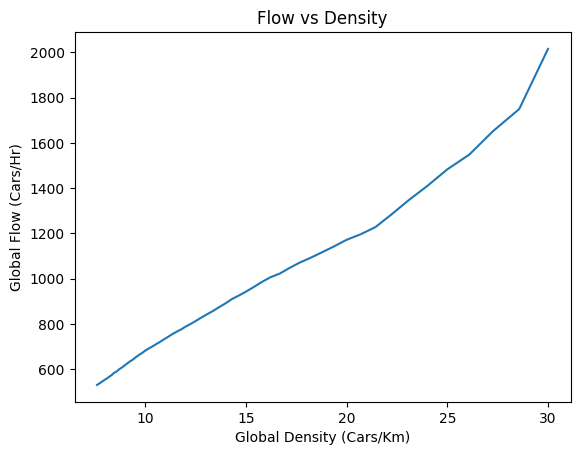

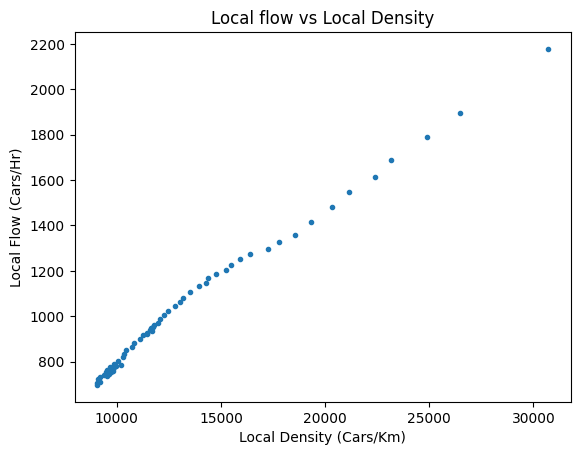

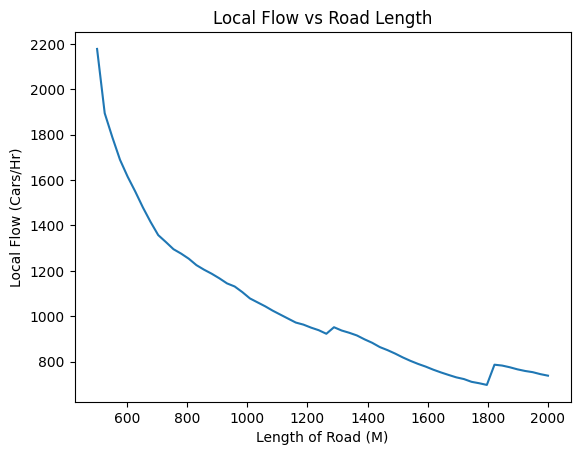

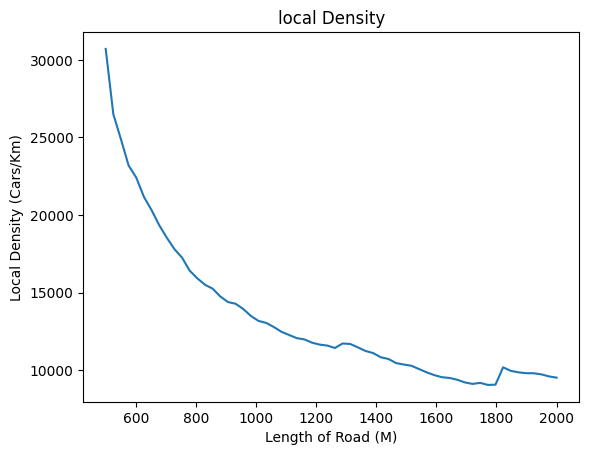

Average Velocity vs Global Flow


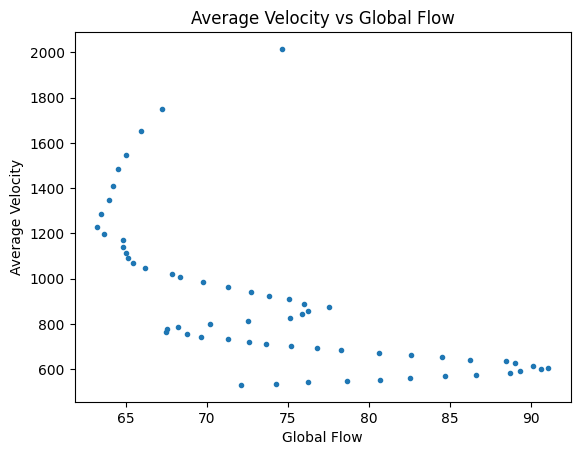

average velocity vs global density


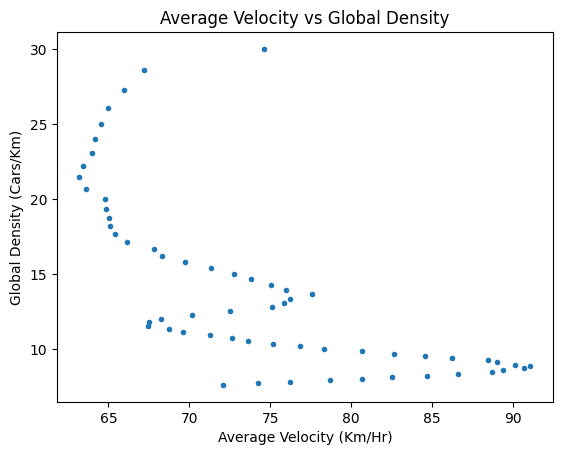

average velocity vs local flow


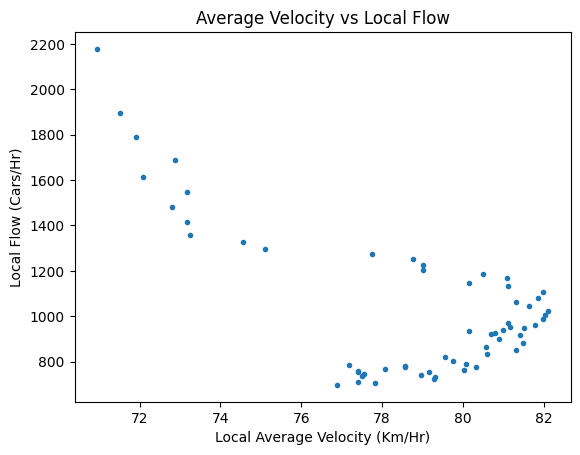

average velocity vs local density


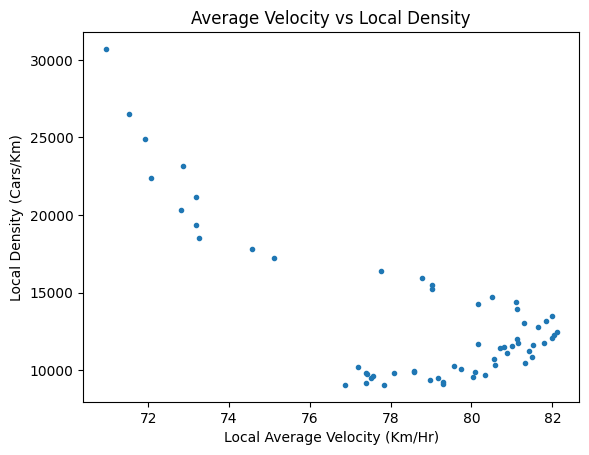

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#
# set up model parameters and road parameters
#
Nmax, L, steps, steps_measure, splim, det_point = init_params()
#
# parameters for the sweep
#
start_L = 500
end_L   = 2000
step_L  = 25
#
# initialise empty lists for the essential data
# data needs retaining for each number of cars in the sweep
#
global_flow   = []
local_flow    = []
global_dens   = []
local_dens    = []
global_av_vel = []
local_av_vel  = []

for L in range(start_L,end_L, step_L):
  params = params_setup(splim,L,current_weather="Wind")

  glob_flow, glob_dens , loc_flow, loc_dens, avg_vel_local, avg_vel_global = Simulate_IDM(15,params,steps,steps_measure)
  print(glob_flow, "global flow")
  print(glob_dens, "global density")
  print(loc_flow, "local flow")
  print(loc_dens, "local density")
  global_flow.append(glob_flow)
  global_dens.append(glob_dens)
  local_flow.append(loc_flow)
  local_dens.append(loc_dens)

  avg_vel_km_per_hour = avg_vel_global * 3.6
  avg_vel_km_per_hour_local = avg_vel_local * 3.6

  global_av_vel.append(avg_vel_km_per_hour)
  local_av_vel.append(avg_vel_km_per_hour_local)




length1 = np.linspace(start_L, end_L, len(global_flow))
Lengths = np.array(length1)

# Plot 1: Global Flow
plt.plot(Lengths, global_flow)
plt.title("Global Flow vs Road Length")
plt.xlabel("Road length (M)")
plt.ylabel("Global Flow (Cars/Hr)")
plt.savefig("global_flow.png")  # Saves in current folder
plt.show()
plt.close()

# Plot 2: Global Density
plt.plot(Lengths, global_dens)
plt.title("Global Density vs Road Length")
plt.xlabel("Road Length (M)")
plt.ylabel("Global Density (Cars/Km)")
plt.savefig("global_density.png")
plt.show()
plt.close()

# Plot 3: Flow vs Density
plt.plot(global_dens, global_flow)
plt.title("Flow vs Density")
plt.xlabel("Global Density (Cars/Km)")
plt.ylabel("Global Flow (Cars/Hr)")
plt.savefig("flow_vs_density.png")
plt.show()
plt.close()

# Plot 4: Local Flow vs Local Density (scatter)
plt.scatter(local_dens, local_flow,marker='.')
plt.title("Local flow vs Local Density")
plt.xlabel("Local Density (Cars/Km)")
plt.ylabel("Local Flow (Cars/Hr)")
plt.savefig("local_flow_vs_local_density.png")
plt.show()
plt.close()

# Plot 5: Local Flow
plt.plot(Lengths, local_flow)
plt.title("Local Flow vs Road Length")
plt.xlabel("Length of Road (M)")
plt.ylabel("Local Flow (Cars/Hr)")
plt.savefig("local_flow.png")
plt.show()
plt.close()

# Plot 6: Local Density
plt.plot(Lengths, local_dens)
plt.title("local Density")
plt.xlabel("Length of Road (M)")
plt.ylabel("Local Density (Cars/Km)")
plt.savefig("local_density.png")
plt.show()
plt.close()

# Plot 7: Average velocity vs Global Flow
print("Average Velocity vs Global Flow")
plt.scatter(global_av_vel, global_flow,marker='.')
plt.title("Average Velocity vs Global Flow")
plt.xlabel("Global Flow")
plt.ylabel("Average Velocity")
plt.savefig("avg_vel_vs_global_flow.png")
plt.show()
plt.close()

# Plot 8: Average velocity vs Global Density
print("average velocity vs global density")
plt.scatter(global_av_vel, global_dens,marker='.')
plt.title("Average Velocity vs Global Density")
plt.xlabel("Average Velocity (Km/Hr)")
plt.ylabel("Global Density (Cars/Km)")
plt.savefig("avg_vel_vs_global_density.png")
plt.show()
plt.close()

# Plot 9: Average velocity vs Local Flow
print("average velocity vs local flow")
plt.scatter(local_av_vel, local_flow,marker='.')
plt.title("Average Velocity vs Local Flow")
plt.xlabel("Local Average Velocity (Km/Hr)")
plt.ylabel("Local Flow (Cars/Hr)")
plt.savefig("avg_vel_vs_local_flow.png")
plt.show()
plt.close()

# Plot 10: Average velocity vs Local Density
print("average velocity vs local density")
plt.scatter(local_av_vel, local_dens,marker='.')
plt.title("Average Velocity vs Local Density")
plt.xlabel("Local Average Velocity (Km/Hr)")
plt.ylabel("Local Density (Cars/Km)")
plt.savefig("avg_vel_vs_local_density.png")
plt.show()
plt.close()